# Covid-19 display

Simple display of covid-19 data with matplotlib, seaborn, geopandas and plotly dash


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data collection and basic plots

Let's grab the latest figures from the Johns Hopkins github repo

In [3]:
filenames = ['confirmed', 'deaths', 'recovered']
baseURL = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_"

In [4]:
#download and join the three csv files + basic data cleaning
df_list = [pd.read_csv(baseURL + i + '_global.csv') for i in filenames]
for df,kind in zip(df_list,filenames):
    df['kind'] = kind
df = pd.concat(df_list)
df.rename(columns={'Country/Region':'Country'}, inplace = True)


In [5]:
#aggregate data by country and prepare time series for plotting
df = df.groupby(['Country','kind']).sum()
df.reset_index(inplace = True)
df_melt = df.drop(['Lat','Long'], axis = 1).melt(
    id_vars = ['Country','kind'], value_name = 'value', var_name = 'date')
df_melt.date = pd.to_datetime(df_melt.date)
#df_melt.drop_duplicates(subset = ['Country','date'],inplace = True)

In [6]:
#extract the last day 
lastday = df_melt.date.max()

In [7]:
#create a new df with only the aggragate data for the last day
df_lastday = df_melt.query('kind == "confirmed" and date == @lastday')[['Country','value']]
df_lastday = df_lastday.groupby('Country').sum().sort_values(by='value', ascending = False).reset_index()

### Plot the current number of confirmed cases for the 5 most affected countries

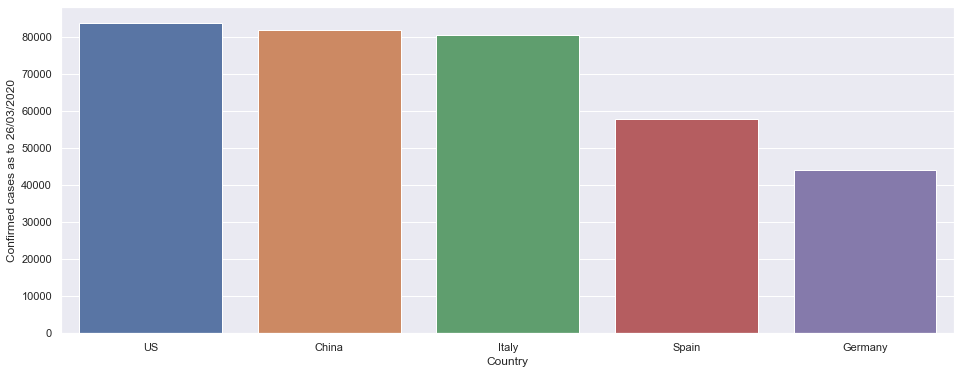

In [8]:
plt.subplots(figsize = (16,6))
sns.barplot(data = df_lastday[:5], x = "Country", y = 'value')
plt.ylabel('Confirmed cases as to ' + lastday.strftime("%d/%m/%Y"));

Let's do the same for Europe only

In [9]:
#grab the list of european countries from wikipedia
europe_url = "https://en.wikipedia.org/wiki/List_of_European_countries_by_area"

In [10]:
#download and clean the list
europe = pd.read_html(europe_url)[0]['State'].apply(lambda x: x.replace('*',''))
europe.replace('United Kingdom','UK', inplace = True)
europe = europe.tolist()

In [11]:
#create a new df for european countries
df_europe = df_lastday.query('Country == @europe')

### Plot the current number of confirmed cases for the 5 most affected european countries

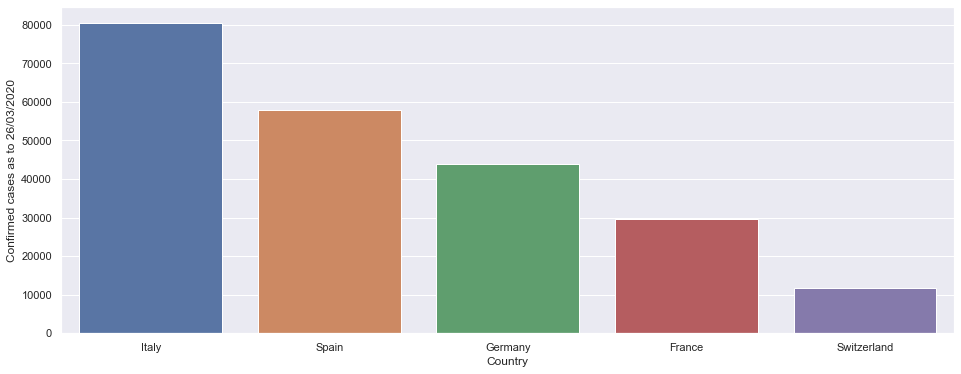

In [12]:
plt.subplots(figsize = (16,6))
sns.barplot(data = df_europe[:5], x = 'Country', y = 'value')
plt.ylabel('Confirmed cases as to ' + lastday.strftime("%d/%m/%Y"));

In [13]:
#create the list of top 5 european countries + USA
europe_top5 = df_europe[:5].Country.tolist() + ["US"]

### Plot the time series of confirmed cases for the 5 most affected european countries + USA

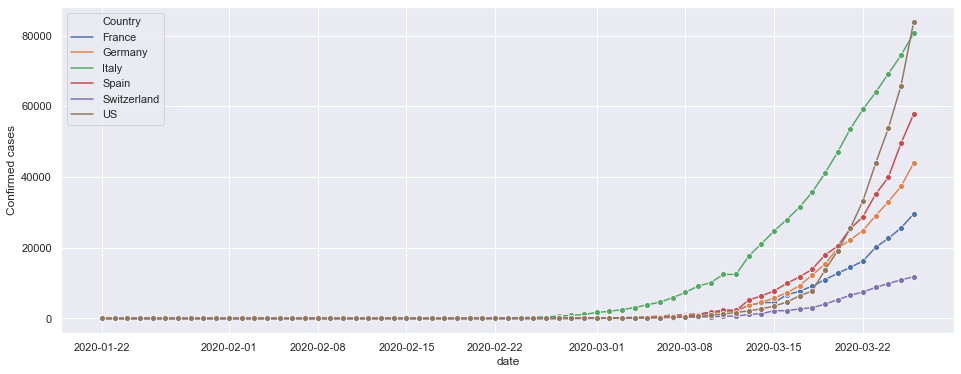

In [14]:
plt.subplots(figsize = (16,6))
ax = sns.lineplot(data = df_melt.query('Country == @europe_top5 and kind == "confirmed"'), 
                     x = 'date', y = 'value', hue = 'Country', marker = 'o')
plt.ylabel('Confirmed cases');

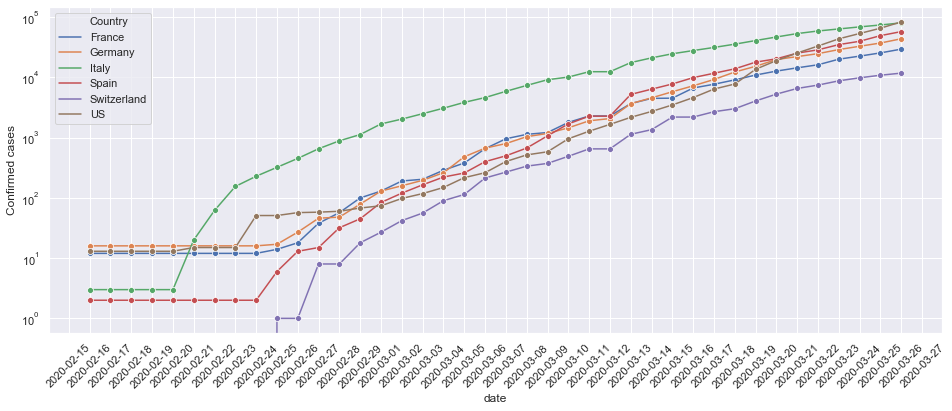

In [15]:
# Now let's do the same in log scale
from matplotlib.ticker import MultipleLocator

plt.subplots(figsize = (16,6))
ax = sns.lineplot(data = df_melt.query('Country == @europe_top5 and kind == "confirmed" and date > "2020-02-15"'), 
                     x = 'date', y = 'value', hue = 'Country', marker = 'o')
ax.set(yscale="log")
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation='45') 
plt.ylabel('Confirmed cases');

Those really look like parallel curves, with aobut 7 days delay between Italy and France/Germany/Spain

## Visualizing data on a map

I'll use geopandas to draw the map data

In [16]:
import geopandas as gpd

In [17]:
#use the default world coordinate data from geopandas and basic data cleaning
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.name.replace({#'United Kingdom':'UK', 
                     #'Czechia': 'Czech Republic',
                   'Bosnia and Herz.': 'Bosnia and Herzegovina',
                    'Macedonia': 'North Macedonia'},
                     inplace = True)
world.loc[world.name == 'France', 'iso_a3'] = "FRA"
world.loc[world.name == 'Norway', 'iso_a3'] = "NOR"
#world.loc[world.name == 'Kosovo', 'iso_a3'] = "XKX"
world.rename(columns={'name':'Country'}, inplace = True)

In [18]:
#join the geodata df with the covid data
world = world.set_index('Country').join(df_lastday.set_index('Country'), on='Country')
world.reset_index(inplace= True)
world.value.fillna(0, inplace=True)
world['logvalue'] = world.value.apply(lambda x: np.log(x+1)) #use log for better data display

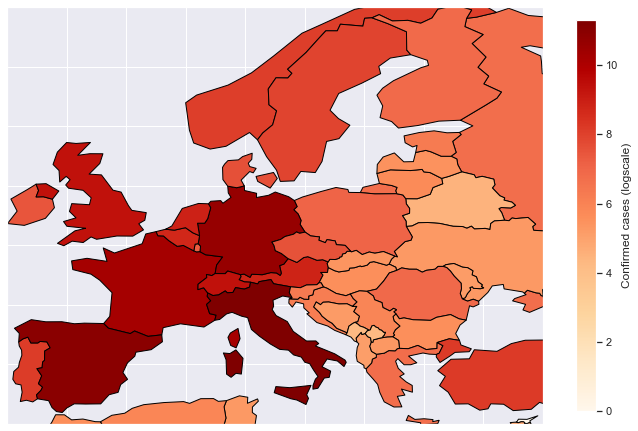

In [19]:
#plot data and zoom in on Europe
ax = world.plot(figsize = (12,12), column = 'logvalue', legend = True, cmap='OrRd', edgecolor='black',
          legend_kwds = {'label': 'Confirmed cases (logscale)', 'shrink': 0.6})
ax.set_xlim((-10,35))
ax.set_ylim((35,70))
plt.xticks(visible = False)
plt.yticks(visible = False);

## Interactive plotting with Dash

In [20]:
from jupyter_plotly_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

In [21]:
app = JupyterDash('GeoCovid')

In [22]:
fig = px.choropleth(world, 
                    locations="iso_a3",
                    scope = 'europe',
                    color="logvalue", 
                    hover_name="Country",
                    labels={'value':'confirmed'},
                    height = 700,
                    width = 1000,
                    hover_data=["value"],
                    
                    color_continuous_scale="OrRd")
fig.layout.coloraxis.showscale = False
fig.layout.dragmode =  False

In [23]:
app.layout = html.Div([
    html.Div([
        dcc.Graph(
            id='main',
            figure = fig
             
        )
    ], style={'width': '40%', 'display': 'inline-block', 'padding': '0'}),
])

In [24]:
app

app.layout = html.Div([
    html.Div([
        dcc.Graph(
            id='main',
            figure = fig
             
        )
    ], style={'width': '40%', 'display': 'inline-block', 'padding': '0'}),
    html.Div([
            dcc.Textarea(
                placeholder='Enter a value...',
                value='This is a TextArea component',
                id='textbox',
                style={'width': '100%'}
            )  
        ]),
    html.Div([
       dcc.Graph(id='time-series'),
    ], style={'display': 'inline-block', 'width': '49%', 'padding': '0'})
])

def create_time_series(df, title):
    return {
        'data': [dict(
            x=df['date'],
            y=df['value'],
            mode='lines+markers'
        )],
        'layout': {
            'height': 225,
            'margin': {'l': 20, 'b': 30, 'r': 10, 't': 10},
            'annotations': [{
                'x': 0, 'y': 0.85, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(255, 255, 255, 0.5)',
                'text': title
            }],
            'yaxis': {'type': 'linear'},
            'xaxis': {'showgrid': False}
        }
    }

@app.callback(
    Output('textbox', 'value'),
    [Input('main', 'hoverData')])
def display_hover_data(hoverData):
    return json.dumps(hoverData, indent=2)



@app.callback(
    dash.dependencies.Output('time-series', 'figure'),
    [dash.dependencies.Input('main', 'hoverData')])
def update_timeseries(hoverData):
    country = hoverData['points'][0]['hoverinfo']
    dfx = df_melt[df_melt.Country == "Italy"]
    title = '<b>{}</b><br>{}'.format(country)
    return create_time_series(dfx, "Italy")

app